In [55]:
from patchseq_utils import clustering as uc, pipelines as up, analysis as utils
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:

pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')
from importlib import reload

In [62]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [63]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
import sklearn.metrics as metrics

In [6]:
pd.set_option('use_inf_as_na', True)

# Subclass clustering

## L1 core types

In [7]:
l1_data = subset_data(
    human_df.query("collaborator=='AIBS' & core_l1_type & failed_fx_long_squares==False & layer=='1'"),
                                ephys_features, ephys_frac_min=0, cluster_min=0)

In [8]:
l1_features = subset_features(l1_data, ephys_features, complete_frac=0.6)
set(ephys_features).difference(l1_features)

{'3db_freq_chirp',
 'adp_v_last_rheo',
 'low_freq_impedance_chirp',
 'peak_freq_chirp',
 'peak_impedance_chirp',
 'peak_ratio_chirp',
 'phase_low_chirp',
 'phase_peak_chirp',
 'sag_tau_depol',
 'sync_freq_chirp',
 'total_inductive_phase_chirp'}

In [9]:
l1_data, norm_features = uc.add_norm_features_and_impute(l1_data, l1_features)
l1_data['homology_type'].value_counts(dropna=False)

LAMP5     86
PAX6      32
MC4R      31
L1 VIP    15
Name: homology_type, dtype: int64

In [10]:
data = l1_data
cluster_var = 'homology_type'
keys = l1_data[cluster_var].unique()

cache_dir = "/local1/storage/temp/"
cache_dir=None
# clf = LabeledGMM(n_components=2, init_params='kmeans')
clf = QuadraticDiscriminantAnalysis(priors=(0.5, 0.5))
pipe = uc.make_pipeline(clf, memory=cache_dir)

In [11]:
results = [uc.cluster_combinations_gmm(pipe, data, norm_features, cluster_var, cluster_name) 
                    for cluster_name in keys]

In [12]:
df_all = pd.concat(results, keys=keys, names=['type'])

top = df_all.reset_index(level=0).groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
L1 VIP,"norm_sag, norm_fi_fit_slope",0.496234,0.823106
LAMP5,"norm_threshold_i_ramp, norm_upstroke_adapt_ratio",0.848282,0.847917
MC4R,"norm_sag, norm_threshold_v_adapt_ratio",0.798650,0.901705
PAX6,"norm_sag_peak_t, norm_trough_v_rheo",0.873846,0.944886


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


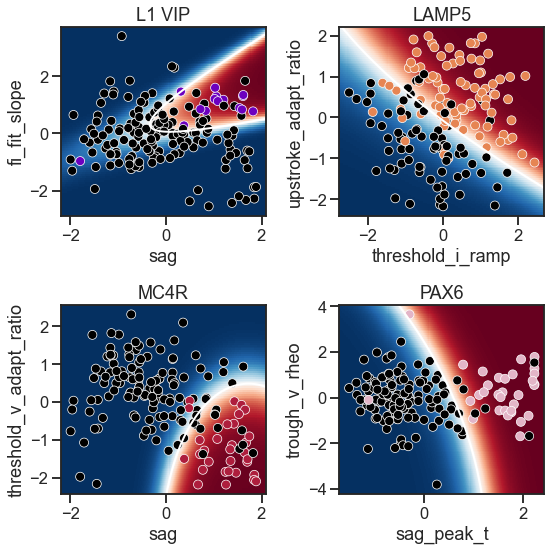

In [13]:
i = 0
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = np.ravel(axs)
for name, row in top.iterrows():
    features = row['features'].split(', ')
    uc.plot_feature_set_gmm(pipe, data, features, cluster_var, name, ax=axs[i], palette=palette_subclass)
    i+=1
plt.tight_layout()

In [14]:
clf = uc.LabeledGMM(n_components=2, init_params='kmeans', n_init=5)
pipe = uc.make_pipeline(clf, memory=cache_dir)

In [15]:
results = [uc.cluster_combinations_gmm(pipe, data, norm_features, cluster_var, cluster_name) 
                    for cluster_name in keys]

In [16]:
df_all = pd.concat(results, keys=keys, names=['type'])

top = df_all.reset_index(level=0).groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
L1 VIP,"norm_fi_fit_slope, norm_downstroke_rheo",0.416667,0.829268
LAMP5,"norm_upstroke_downstroke_ratio_ramp, norm_upst...",0.857143,0.835366
MC4R,"norm_sag, norm_upstroke_hero",0.727273,0.871951
PAX6,"norm_sag_peak_t, norm_fast_trough_deltav_hero",0.909091,0.963415


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(


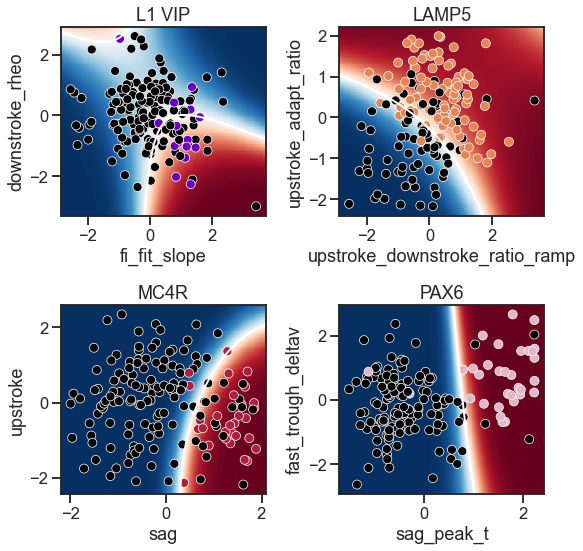

In [17]:
i = 0
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = np.ravel(axs)
for name, row in top.iterrows():
    features = row['features'].split(', ')
    uc.plot_feature_set_gmm(pipe, data, features, cluster_var, name, ax=axs[i], palette=palette_subclass)
    i+=1
plt.tight_layout()

## L1 types, VIP grouped

In [42]:
l1_data = subset_data(
    human_df.query("collaborator=='AIBS' & l1_type & failed_fx_long_squares==False & layer=='1'"),
                                ephys_features, ephys_frac_min=0, cluster_min=0)

In [43]:
l1_data, norm_features = uc.add_norm_features_and_impute(l1_data, l1_features)
other = 'all others'
palette=palette_subclass.copy()
palette[other] = palette['L1 VIP']
l1_data['homology_type'] = l1_data['homology_type'].replace(['other',  'L1 VIP'], other)
l1_data['homology_type'].value_counts(dropna=False)

LAMP5         86
PAX6          32
MC4R          31
all others    28
Name: homology_type, dtype: int64

### GMM

In [45]:

data = l1_data
cluster_var = 'homology_type'
keys = l1_data[cluster_var].unique()
cache_dir = "/local1/storage/temp/"
clf = uc.LabeledGMM(n_components=2, init_params='kmeans', n_init=5)
pipe = uc.make_pipeline(clf, memory=cache_dir)

In [46]:
results = [uc.cluster_combinations_gmm(pipe, data, norm_features, cluster_var, cluster_name) 
                    for cluster_name in keys]
df_all = pd.concat(results, keys=keys, names=['type'])

In [47]:
top = df_all.reset_index(level=0).loc[lambda df: ~df.features.str.contains(',')].groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,norm_upstroke_adapt_ratio,0.766839,0.745763
MC4R,norm_sag,0.632653,0.796610
PAX6,norm_sag_peak_t,0.731707,0.875706
all others,norm_upstroke_downstroke_ratio_ramp,0.453608,0.700565


In [48]:
top = df_all.reset_index(level=0).groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,"norm_upstroke_downstroke_ratio_ramp, norm_upst...",0.805687,0.768362
MC4R,"norm_sag_tau, norm_upstroke_adapt_ratio",0.693333,0.870056
PAX6,"norm_fast_trough_deltav_ramp, norm_sag_peak_t",0.892308,0.960452
all others,"norm_upstroke_downstroke_ratio_rheo, norm_upst...",0.500000,0.796610


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(


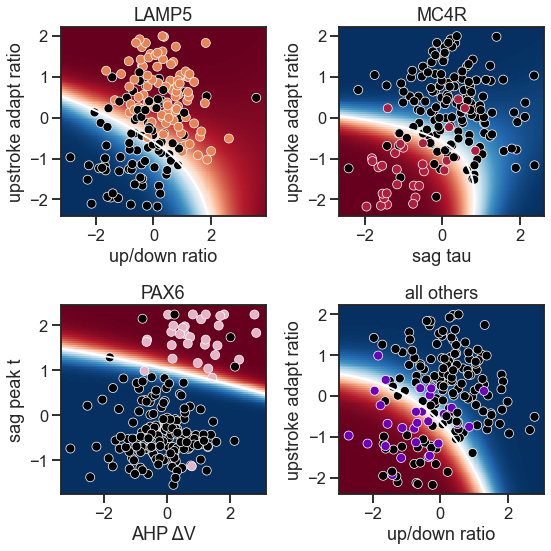

In [49]:
i = 0
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = np.ravel(axs)
for name, row in top.iterrows():
    features = row['features'].split(', ')
    feature_names = [feature_name(x) for x in features]
    uc.plot_feature_set_gmm(pipe, data, features, cluster_var, name, 
                            feature_names=feature_names, ax=axs[i], palette=palette)
    i+=1
plt.tight_layout()

### QDA

In [25]:

clf = QuadraticDiscriminantAnalysis(priors=(0.5, 0.5))
pipe = uc.make_pipeline(clf, memory=cache_dir)

In [26]:
results = [uc.cluster_combinations_gmm(pipe, data, norm_features, cluster_var, cluster_name) 
                    for cluster_name in keys]
df_all = pd.concat(results, keys=keys, names=['type'])

In [27]:
top = df_all.reset_index(level=0).loc[lambda df: ~df.features.str.contains(',')].groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,norm_upstroke_adapt_ratio,0.752147,0.746667
MC4R,norm_sag,0.679187,0.829524
PAX6,norm_sag_peak_t,0.797459,0.909206
all others,norm_sag_area,0.457115,0.660000


In [28]:
top = df_all.reset_index(level=0).groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,"norm_upstroke_downstroke_ratio_ramp, norm_upst...",0.840281,0.831270
MC4R,"norm_sag, norm_threshold_v_adapt_ratio",0.757443,0.874603
PAX6,"norm_sag_peak_t, norm_trough_v_rheo",0.856557,0.943492
all others,"norm_upstroke_downstroke_ratio_ramp, norm_ahp_...",0.559075,0.806825


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


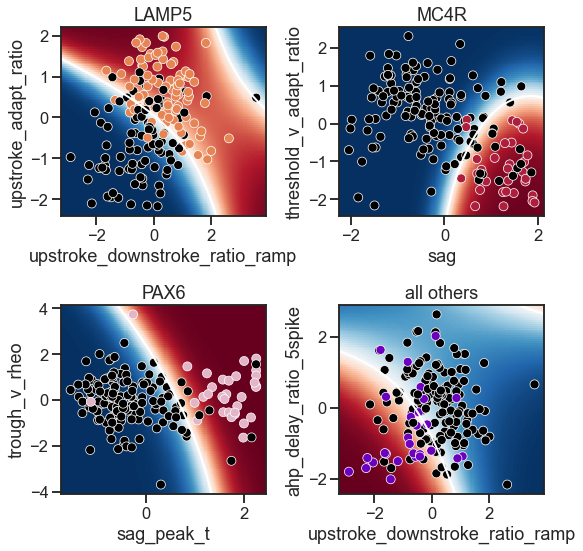

In [29]:
i = 0
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = np.ravel(axs)
for name, row in top.iterrows():
    features = row['features'].split(', ')
    uc.plot_feature_set_gmm(pipe, data, features, cluster_var, name, ax=axs[i], palette=palette)
    i+=1
plt.tight_layout()

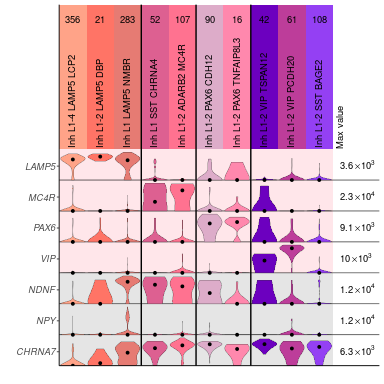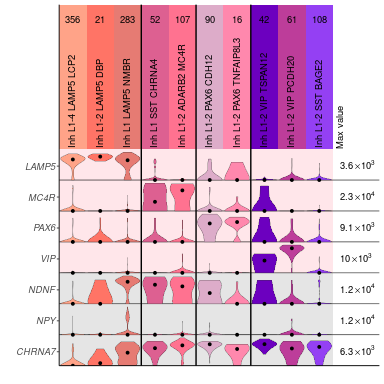## L1 all, VIP grouped

In [30]:
l1_data = subset_data(
    human_df.query("collaborator=='AIBS' & failed_fx_long_squares==False & layer=='1'"),
                                ephys_features, ephys_frac_min=0, cluster_min=0)

In [31]:
l1_data, norm_features = uc.add_norm_features_and_impute(l1_data, l1_features)
other = 'all others'
palette=palette_subclass.copy()
palette[other] = palette['L1 VIP']
l1_data['homology_type'] = l1_data['homology_type'].replace(['other',  'L1 VIP'], other)
l1_data['homology_type'].value_counts(dropna=False)

LAMP5         86
PAX6          32
MC4R          31
all others    28
NaN           16
Name: homology_type, dtype: int64

In [32]:

data = l1_data
cluster_var = 'homology_type'
keys =  ['PAX6', 'LAMP5', 'MC4R', 'all others']


clf = uc.LabeledGMM(n_components=2, init_params='kmeans', n_init=5)
pipe = uc.make_pipeline(clf, memory=cache_dir)

In [33]:
results = [uc.cluster_combinations_gmm(pipe, data, norm_features, cluster_var, cluster_name) 
                    for cluster_name in keys]
df_all = pd.concat(results, keys=keys, names=['type'])

In [34]:
top = df_all.reset_index(level=0).loc[lambda df: ~df.features.str.contains(',')].groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,norm_upstroke_adapt_ratio,0.738462,0.735751
MC4R,norm_sag,0.607843,0.792746
PAX6,norm_sag_peak_t,0.588235,0.782383
all others,norm_sag,0.404040,0.694301


In [35]:
top = df_all.reset_index(level=0).groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,"norm_upstroke_downstroke_ratio_ramp, norm_upst...",0.809524,0.792746
MC4R,"norm_sag, norm_isi_cv_hero",0.688525,0.901554
PAX6,"norm_sag_peak_t, norm_sag_tau",0.681818,0.854922
all others,"norm_upstroke_downstroke_ratio_ramp, norm_fast...",0.465116,0.761658


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LabeledGMM was fitted with feature names
  warnings.warn(


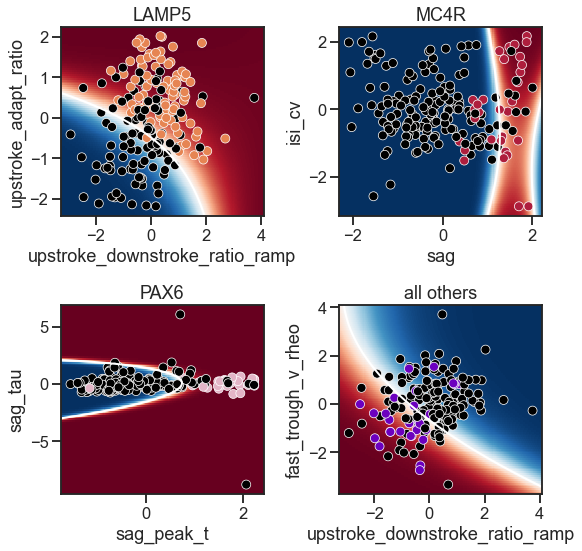

In [36]:
i = 0
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = np.ravel(axs)
for name, row in top.iterrows():
    features = row['features'].split(', ')
    uc.plot_feature_set_gmm(pipe, data, features, cluster_var, name, ax=axs[i], palette=palette)
    i+=1
plt.tight_layout()

In [37]:

clf = QuadraticDiscriminantAnalysis(priors=(0.5, 0.5))
pipe = uc.make_pipeline(clf, memory=cache_dir)

In [38]:
results = [uc.cluster_combinations_gmm(pipe, data, norm_features, cluster_var, cluster_name) 
                    for cluster_name in keys]
df_all = pd.concat(results, keys=keys, names=['type'])

In [39]:
top = df_all.reset_index(level=0).loc[lambda df: ~df.features.str.contains(',')].groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,norm_upstroke_adapt_ratio,0.722634,0.735628
MC4R,norm_sag,0.660140,0.832928
PAX6,norm_sag_peak_t,0.742353,0.880027
all others,norm_upstroke_downstroke_ratio_ramp,0.444099,0.677328


In [40]:
top = df_all.reset_index(level=0).groupby('type').first()
top

,features,f1_score,accuracy_score
type,,,
LAMP5,"norm_upstroke_downstroke_ratio_ramp, norm_upst...",0.821784,0.823617
MC4R,"norm_sag, norm_threshold_v_adapt_ratio",0.722984,0.858435
PAX6,"norm_sag_peak_t, norm_fast_trough_deltav_hero",0.816429,0.926991
all others,"norm_upstroke_downstroke_ratio_ramp, norm_widt...",0.509879,0.718893


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


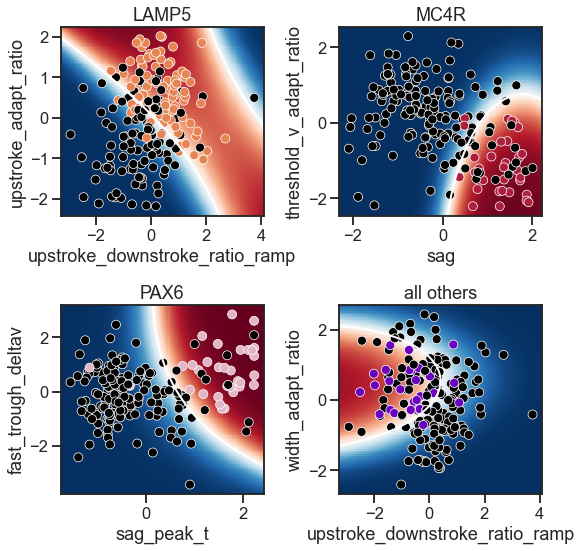

In [41]:
i = 0
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = np.ravel(axs)
for name, row in top.iterrows():
    features = row['features'].split(', ')
    uc.plot_feature_set_gmm(pipe, data, features, cluster_var, name, ax=axs[i], palette=palette)
    i+=1
plt.tight_layout()

# Classification

## Excluding features

In [64]:
inh_df = subset_data(
    human_df.query("core_l1_type & failed_fx_long_squares==False & layer=='1'"),
                                ephys_features, ephys_frac_min=0, cluster_min=0)

In [65]:
features_common = inh_df.groupby('collaborator')[ephys_features].apply(
    lambda x: x.notna().mean(axis=0)).min().loc[lambda x: x>0.5].index
set(ephys_features).difference(features_common)

{'3db_freq_chirp',
 'adp_v_last_rheo',
 'downstroke_short_square',
 'first_isi_inv_rheo',
 'low_freq_impedance_chirp',
 'mean_isi_rheo',
 'peak_deltav_short_square',
 'peak_freq_chirp',
 'peak_impedance_chirp',
 'peak_ratio_chirp',
 'phase_low_chirp',
 'phase_peak_chirp',
 'sag_peak_t',
 'sag_peak_t_depol',
 'sag_tau_depol',
 'sync_freq_chirp',
 'threshold_v_short_square',
 'total_inductive_phase_chirp',
 'upstroke_downstroke_ratio_short_square',
 'upstroke_short_square',
 'width_short_square',
 'width_suprathresh_short_square'}

In [66]:
# features = [f for f in ephys_all if ('3db' not in f) and ('short_square' not in f)]
# features = ephys_features
results = utils.run_regressions(inh_df, features_common, variable='collaborator')

In [67]:
results.sort_values('rsquared', ascending=False).head(10)

,aic,bic,fvalue,f_pvalue,llf,rsquared,rsquared_adj,nobs,pval_collaborator,fval_collaborator,eta_p_collaborator,model,pval_collaborator_fdr
feature,,,,,,,,,,,,,
upstroke_ramp,2122.832629,2132.461087,24.160357,5.075132e-10,-1058.416314,0.446026,0.439870,183.0,5.075132e-10,24.160357,0.211635,collaborator,7.308190e-09
upstroke_rheo,2233.983701,2243.724773,22.785673,1.393750e-09,-1113.991851,0.432414,0.426344,190.0,1.393750e-09,22.785673,0.195946,collaborator,1.672500e-08
downstroke_rheo,1890.646902,1900.387974,12.027927,1.219083e-05,-942.323451,0.425819,0.419678,190.0,1.219083e-05,12.027927,0.113979,collaborator,6.661824e-05
upstroke_hero,2251.338642,2261.079714,19.104924,2.820138e-08,-1122.669321,0.395277,0.388809,190.0,2.820138e-08,19.104924,0.169663,collaborator,2.900713e-07
width_suprathresh_rheo,-2901.958344,-2892.233103,33.892152,2.815019e-13,1453.979172,0.359144,0.352253,189.0,2.815019e-13,33.892152,0.267094,collaborator,1.013407e-11
downstroke_hero,1925.981762,1935.722834,11.959456,1.295355e-05,-959.990881,0.349271,0.342311,190.0,1.295355e-05,11.959456,0.113403,collaborator,6.661824e-05
width_rheo,-2865.809548,-2856.084306,27.888039,2.554256e-11,1435.904774,0.331532,0.324344,189.0,2.554256e-11,27.888039,0.230693,collaborator,4.597661e-10
downstroke_ramp,1721.997208,1731.625666,8.435491,3.148992e-04,-857.998604,0.324358,0.316851,183.0,3.148992e-04,8.435491,0.085696,collaborator,1.333691e-03
width_suprathresh_hero,-2913.295167,-2903.569926,11.467690,2.011819e-05,1459.647584,0.317552,0.310214,189.0,2.011819e-05,11.467690,0.109773,collaborator,9.656733e-05


In [69]:
# one v rest cluster features
feats = [
    'upstroke_adapt_ratio',
    'upstroke_downstroke_ratio_ramp',
    # 'sag_peak_t',
    'sag',
    'trough_slowdeltav_rheo'
]
results.loc[feats]

,aic,bic,fvalue,f_pvalue,llf,rsquared,rsquared_adj,nobs,pval_collaborator,fval_collaborator,eta_p_collaborator,model,pval_collaborator_fdr
feature,,,,,,,,,,,,,
upstroke_adapt_ratio,-240.222746,-230.513421,0.630291,0.533576,123.111373,0.013631,0.002967,188.0,0.533576,0.630291,0.006768,collaborator,0.674509
upstroke_downstroke_ratio_ramp,262.649701,272.278159,3.653109,0.027850,-128.324850,0.063571,0.053167,183.0,0.027850,3.653109,0.039007,collaborator,0.069145
sag,-266.772649,-257.031576,0.220169,0.802591,136.386324,0.004258,-0.006392,190.0,0.802591,0.220169,0.002349,collaborator,0.862486
trough_slowdeltav_rheo,893.788377,903.513618,1.027155,0.360046,-443.894189,0.015289,0.004700,189.0,0.360046,1.027155,0.010924,collaborator,0.529047


In [75]:
ephys_features_aligned = list(results[(results.rsquared<0.05) & (results.pval_collaborator>0.05)].index)
ephys_features_aligned

['trough_v_hero',
 'sag_depol',
 'postap_slope_hero',
 'rheobase_i',
 'isi_adapt_ratio',
 'adapt_hero',
 'ir_late_hero',
 'fast_trough_v_rheo',
 'input_resistance_ss',
 'fast_trough_v_last_rheo',
 'adapt_mean',
 'fast_trough_deltav_ramp',
 'avg_rate_max',
 'first_isi_inv_hero',
 'width_adapt_ratio',
 'trough_slowdeltav_rheo',
 'upstroke_adapt_ratio',
 'mean_isi_hero',
 'upstroke_downstroke_ratio_rheo',
 'avg_rate_hero',
 'threshold_v_adapt_ratio',
 'latency_hero',
 'trough_slowdeltav_hero',
 'sag_area',
 'fast_trough_v_hero',
 'downstroke_adapt_ratio',
 'fi_fit_slope',
 'sag',
 'peak_v_adapt_ratio',
 'threshold_i_ramp',
 'median_isi_hero',
 'avg_rate_rheo',
 'upstroke_downstroke_ratio_hero',
 'ahp_delay_ratio_hero',
 'trough_v_rheo']

## Classifiers

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import plot_confusion_matrix

In [112]:
data = inh_df.loc[lambda df: (df.collaborator=='AIBS') ]

X = data[ephys_features_aligned].values
label = 'homology_type'
types = data[label]
y = types.cat.codes
types.value_counts()

LAMP5     86
PAX6      32
MC4R      31
L1 VIP    15
Name: homology_type, dtype: int64

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

CV accuracy: 0.80+/-0.07


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

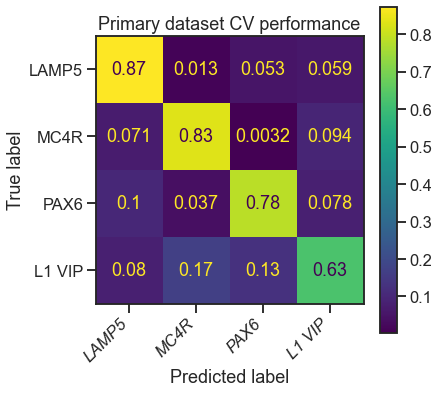

In [111]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
#     ('class', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen', n_components=2))
    ('class', LogisticRegression(class_weight='balanced'))
    # ('class', RandomForestClassifier(class_weight='balanced'))
])
pipeline.fit(X, y)
scoring='accuracy'
cv=RepeatedStratifiedKFold()
scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv)
print("CV accuracy: {:.2f}+/-{:.2f}".format(np.mean(scores), np.std(scores)))

import ateam.analysis.classification as ac
from sklearn.metrics import ConfusionMatrixDisplay

cm = ac.cv_confusion_matrix(X, y.values, pipeline, cv, normalize_axis=1)
cmplot = ConfusionMatrixDisplay(cm, display_labels=types.cat.categories)
fig, ax = plt.subplots(figsize=(6,6))
cmplot.plot(ax=ax)
ax.set_title('Primary dataset CV performance')
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45, fontstyle='italic', ha='right');

In [101]:
data = inh_df.loc[lambda df: (df.collaborator=='AIBS') & (df['topLeafValue'] > 0.5)]

X = data[ephys_features_aligned].values
y = data[label].cat.codes
pipeline.fit(X, y)
pd.Series(np.linalg.norm(pipeline['class'].coef_, axis=0), index=ephys_features_aligned).sort_values(ascending=False)

sag                               1.958100
first_isi_inv_hero                1.455238
threshold_v_adapt_ratio           1.455025
rheobase_i                        1.327688
ahp_delay_ratio_hero              1.239035
latency_hero                      1.214063
upstroke_adapt_ratio              1.199763
trough_slowdeltav_rheo            1.180961
sag_area                          1.098529
peak_v_adapt_ratio                1.085756
fi_fit_slope                      1.084327
downstroke_adapt_ratio            1.001338
fast_trough_deltav_ramp           0.984235
upstroke_downstroke_ratio_rheo    0.978354
upstroke_downstroke_ratio_hero    0.917862
adapt_mean                        0.816796
fast_trough_v_hero                0.813264
trough_v_hero                     0.772098
input_resistance_ss               0.723216
avg_rate_max                      0.679229
ir_late_hero                      0.652592
avg_rate_rheo                     0.645862
threshold_i_ramp                  0.636168
adapt_hero 

In [104]:
data = inh_df.loc[lambda df: (df.collaborator!='AIBS') & df.core_l1_type]

Xtest = data[ephys_features_aligned].values
types = data[label]
ytest = types.cat.codes
types.value_counts()

LAMP5     12
PAX6       6
MC4R       5
L1 VIP     3
Name: homology_type, dtype: int64

Collab test accuracy: 0.81


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


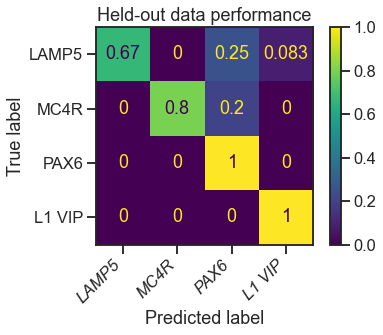

In [105]:
print("Collab test accuracy: {:.2f}".format(pipeline.score(Xtest, ytest)))

cmplot = plot_confusion_matrix(pipeline, Xtest, ytest, display_labels=types.cat.categories, normalize='true')
ax = cmplot.ax_
ax.set_title('Held-out data performance')
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45, fontstyle='italic', ha='right');

In [91]:
data = inh_df.loc[lambda df: (df.collaborator=='Gabor')  & df.core_l1_type]

Xtest = data[ephys_features_aligned].values
# types = data[cluster].astype(ttype_categorical)
types = data[label].astype('category')
types.cat.remove_unused_categories(inplace=True)
ytest = types.cat.codes
types.value_counts()

/tmp/ipykernel_10191/232482883.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  types.cat.remove_unused_categories(inplace=True)


LAMP5     9
PAX6      4
MC4R      3
L1 VIP    1
Name: homology_type, dtype: int64

Tamas test accuracy: 0.76


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


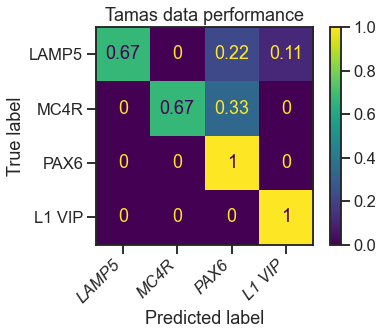

In [92]:
print("Tamas test accuracy: {:.2f}".format(pipeline.score(Xtest, ytest)))

cmplot = plot_confusion_matrix(pipeline, Xtest, ytest, display_labels=types.cat.categories, normalize='true')
ax = cmplot.ax_
ax.set_title('Tamas data performance')
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45, fontstyle='italic', ha='right');

In [93]:
data = inh_df.loc[lambda df: (df.collaborator=='Huib')  & df.core_l1_type]

Xtest = data[ephys_features_aligned].values
# types = data[cluster].astype(ttype_categorical)
types = data[label].astype('category')
types.cat.remove_unused_categories(inplace=True)
ytest = types.cat.codes
types.value_counts()

/tmp/ipykernel_10191/4021191828.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  types.cat.remove_unused_categories(inplace=True)


LAMP5     3
MC4R      2
PAX6      2
L1 VIP    2
Name: homology_type, dtype: int64

Mansvelder test accuracy: 0.89


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


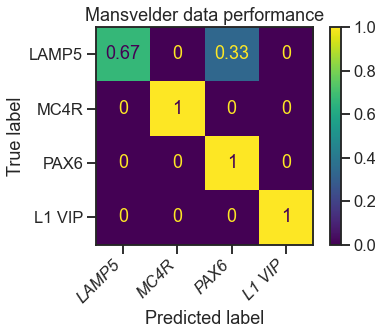

In [94]:
print("Mansvelder test accuracy: {:.2f}".format(pipeline.score(Xtest, ytest)))

cmplot = plot_confusion_matrix(pipeline, Xtest, ytest, display_labels=types.cat.categories, normalize='true')
ax = cmplot.ax_
ax.set_title('Mansvelder data performance')
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45, fontstyle='italic', ha='right');

## Full features set

In [113]:
data = inh_df.loc[lambda df: (df.collaborator=='AIBS') ]

X = data[features_common].values
label = 'homology_type'
types = data[label]
y = types.cat.codes
types.value_counts()

LAMP5     86
PAX6      32
MC4R      31
L1 VIP    15
Name: homology_type, dtype: int64

CV accuracy: 0.84+/-0.06


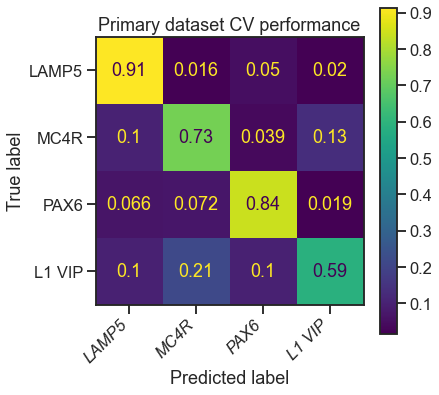

In [114]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
#     ('class', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen', n_components=2))
    ('class', LogisticRegression(class_weight='balanced'))
    # ('class', RandomForestClassifier(class_weight='balanced'))
])
pipeline.fit(X, y)
scoring='accuracy'
cv=RepeatedStratifiedKFold()
scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv)
print("CV accuracy: {:.2f}+/-{:.2f}".format(np.mean(scores), np.std(scores)))

import ateam.analysis.classification as ac
from sklearn.metrics import ConfusionMatrixDisplay

cm = ac.cv_confusion_matrix(X, y.values, pipeline, cv, normalize_axis=1)
cmplot = ConfusionMatrixDisplay(cm, display_labels=types.cat.categories)
fig, ax = plt.subplots(figsize=(6,6))
cmplot.plot(ax=ax)
ax.set_title('Primary dataset CV performance')
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45, fontstyle='italic', ha='right');